Task 4: **Loan Default Risk with Business Cost Optimization, using the Home Credit Default Risk Dataset**

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('credit_risk_dataset.csv')

# Inspect structure
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Shape: (32581, 12)
Columns: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      3

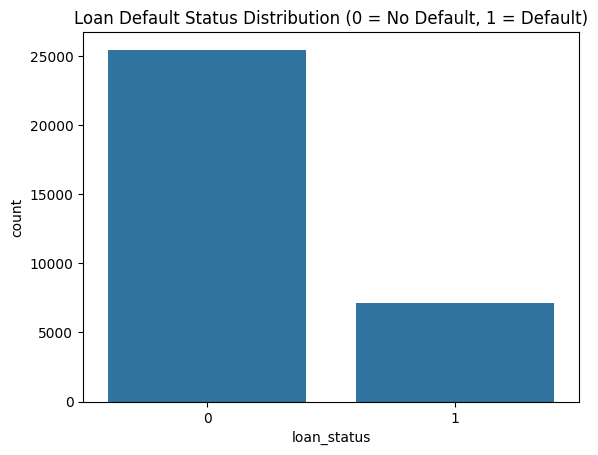

         person_age  person_income  person_emp_length     loan_amnt  \
count  32581.000000   3.258100e+04       31686.000000  32581.000000   
mean      27.734600   6.607485e+04           4.789686   9589.371106   
std        6.348078   6.198312e+04           4.142630   6322.086646   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   29465.000000  32581.000000         32581.000000   
mean       11.011695      0.218164             0.170203   
std         3.240459      0.413006             0.106782   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%   

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Target distribution
sns.countplot(x='loan_status', data=df)
plt.title('Loan Default Status Distribution (0 = No Default, 1 = Default)')
plt.show()

# Numeric feature summary
print(df.describe())


In [3]:
# Map ownership to numeric
df['person_home_ownership'] = df['person_home_ownership'].astype('category').cat.codes
df['loan_intent'] = df['loan_intent'].astype('category').cat.codes
df['loan_grade'] = df['loan_grade'].astype('category').cat.codes
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

# Handle numeric missing values (median imputation)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Define features and target
X = df.drop('loan_status', axis=1)
y = df['loan_status']


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (26064, 11) Test shape: (6517, 11)


In [10]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
# Restart Colab runtime after this if needed, then run:
from catboost import CatBoostClassifier

# Simple model to test
cb = CatBoostClassifier(verbose=0)
cb.fit(X_train, y_train)
y_prob_cb = cb.predict_proba(X_test)[:, 1]
print("CatBoost is working!")

CatBoost is working!


In [17]:
print("Model Coefficients:", lr.coef_)
print("Intercept:", lr.intercept_)
from sklearn.metrics import accuracy_score

y_pred = lr.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Model Coefficients: [[ 0.03326524  0.01628325  0.38676479 -0.03939762 -0.22783561  1.07551354
  -0.50321382 -0.05586122  1.22002566 -0.04282333 -0.01863202]]
Intercept: [-1.81987903]
Accuracy: 0.8448672702163572
Confusion Matrix:
[[4842  253]
 [ 758  664]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      5095
           1       0.72      0.47      0.57      1422

    accuracy                           0.84      6517
   macro avg       0.79      0.71      0.74      6517
weighted avg       0.83      0.84      0.83      6517



In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Costs
cost_fp = 500   # Incorrectly classifying non-default as default
cost_fn = 5000  # Missing actual default

def compute_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * cost_fp + fn * cost_fn

thresholds = np.linspace(0, 1, 101)
cost_lr = [compute_cost(y_test, (y_prob_lr >= t).astype(int)) for t in thresholds]
cost_cb = [compute_cost(y_test, (y_prob_cb >= t).astype(int)) for t in thresholds]

opt_thr_lr = thresholds[np.argmin(cost_lr)]
opt_thr_cb = thresholds[np.argmin(cost_cb)]
print("Optimal LR threshold:", opt_thr_lr, "Cost:", min(cost_lr))
print("Optimal CB threshold:", opt_thr_cb, "Cost:", min(cost_cb))


Optimal LR threshold: 0.14 Cost: 1959500
Optimal CB threshold: 0.1 Cost: 1177000


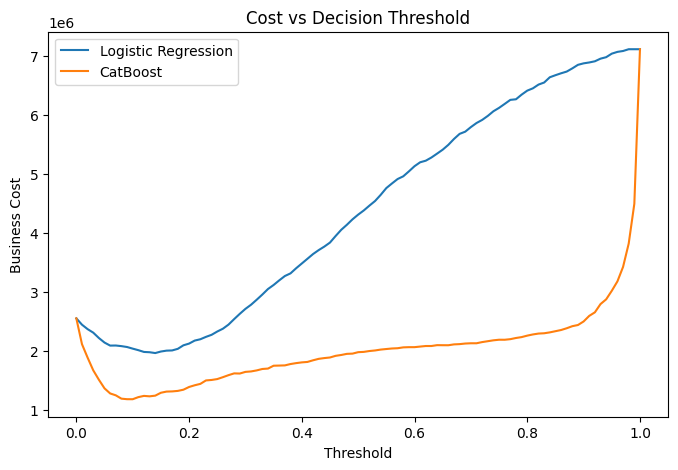

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, cost_lr, label='Logistic Regression')
plt.plot(thresholds, cost_cb, label='CatBoost')
plt.xlabel('Threshold')
plt.ylabel('Business Cost')
plt.title('Cost vs Decision Threshold')
plt.legend()
plt.show()


In [20]:
from sklearn.metrics import classification_report

y_pred_lr = (y_prob_lr >= opt_thr_lr).astype(int)
y_pred_cb = (y_prob_cb >= opt_thr_cb).astype(int)

print("Logistic Regression at optimal threshold:")
print(classification_report(y_test, y_pred_lr))

print("CatBoost at optimal threshold:")
print(classification_report(y_test, y_pred_cb))


Logistic Regression at optimal threshold:
              precision    recall  f1-score   support

           0       0.94      0.60      0.73      5095
           1       0.38      0.87      0.52      1422

    accuracy                           0.66      6517
   macro avg       0.66      0.73      0.63      6517
weighted avg       0.82      0.66      0.69      6517

CatBoost at optimal threshold:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      5095
           1       0.55      0.91      0.68      1422

    accuracy                           0.82      6517
   macro avg       0.76      0.85      0.78      6517
weighted avg       0.88      0.82      0.83      6517



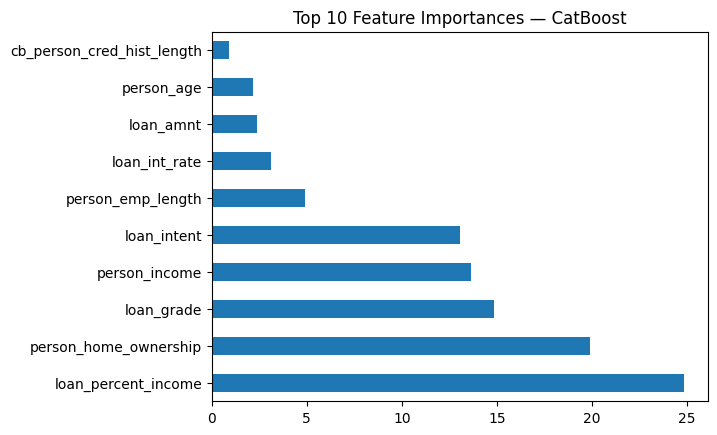

In [21]:
import pandas as pd

fi = pd.Series(cb.get_feature_importance(), index=X_train.columns)
fi.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances — CatBoost')
plt.show()


Optimal Threshold: 0.10
Minimum Total Business Cost: 1,177,000


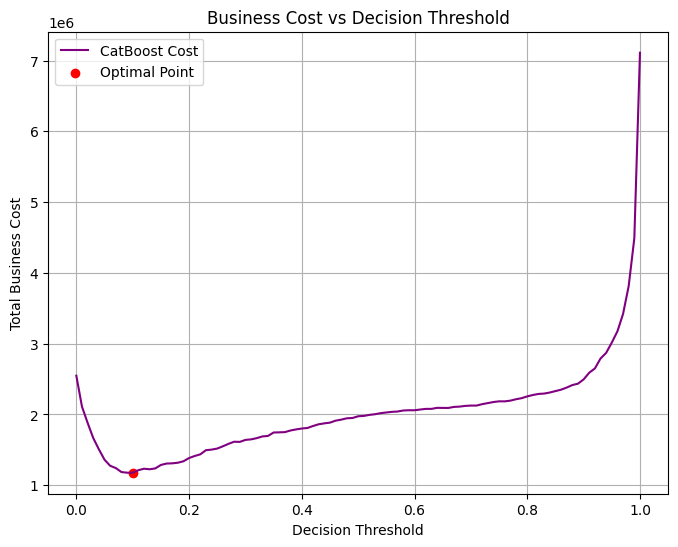

Classification Report at Optimal Threshold:

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      5095
           1       0.55      0.91      0.68      1422

    accuracy                           0.82      6517
   macro avg       0.76      0.85      0.78      6517
weighted avg       0.88      0.82      0.83      6517


❗ Summary:
                 Metric      Value
0    Optimal Threshold        0.1
1  Total Business Cost  1177000.0


In [22]:
# ​​ Generate predicted probabilities with CatBoost
# y_prob_cb will hold probabilities of default (class 1)
y_prob_cb = cb.predict_proba(X_test)[:, 1]

# ​​ Define the business cost scenario
# Example:
# - cost_fp: marking a non-defaulting borrower as defaulting (losing sale)
# - cost_fn: missing a defaulter, letting them go through (high risk)
cost_fp = 500   # Cost per false positive
cost_fn = 5000  # Cost per false negative

from sklearn.metrics import confusion_matrix

def compute_business_cost(y_true, y_pred, cost_fp, cost_fn):
    """
    Calculate total business cost given:
      - y_true: actual labels
      - y_pred: predicted labels (binary)
      - cost_fp: cost of false positives
      - cost_fn: cost of false negatives
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp * cost_fp + fn * cost_fn

# ​​ Sweep across thresholds to calculate total cost each time
import numpy as np

thresholds = np.linspace(0, 1, 101)
cost_cb = []

for thr in thresholds:
    # Convert probabilities to binary predictions using current threshold
    y_pred_thr = (y_prob_cb >= thr).astype(int)
    # Compute cost
    cost_cb.append(compute_business_cost(y_test, y_pred_thr, cost_fp, cost_fn))

# Find the threshold that yields the minimum total cost
optimal_idx = np.argmin(cost_cb)
optimal_threshold = thresholds[optimal_idx]
min_cost = cost_cb[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Minimum Total Business Cost: {min_cost:,}")

# ​​ Visualize Cost vs. Threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, cost_cb, label='CatBoost Cost', color='purple')
plt.scatter(optimal_threshold, min_cost, color='red', label='Optimal Point')
plt.title('Business Cost vs Decision Threshold')
plt.xlabel('Decision Threshold')
plt.ylabel('Total Business Cost')
plt.legend()
plt.grid(True)
plt.show()

# ​​ Final Evaluation at Optimal Threshold
from sklearn.metrics import classification_report

y_pred_final = (y_prob_cb >= optimal_threshold).astype(int)

print("Classification Report at Optimal Threshold:\n")
print(classification_report(y_test, y_pred_final))

# Summarized results in a DataFrame
import pandas as pd

results_summary = pd.DataFrame({
    'Metric': ['Optimal Threshold', 'Total Business Cost'],
    'Value': [optimal_threshold, min_cost]
})
print("\n❗ Summary:\n", results_summary)
